We import sympy and define some variables that we will use frequently. 
- x, y, v, w are the position and velocity components in cartesian coordinates,
- th, ph, that is, $\theta, \varphi$ are polar coordinates for position and velocity,
- R is the radius of the magnetic disc
- b is the magnetic field strength
- Mx and My are integers, $(M_x+1/2, M_y+1/2)$ refers to a center of a magnetic disc
- d will be used as a small positive displacement

In [1]:
from sympy import *

init_printing(use_latex=True)

x, y, v, w     = symbols('x y v w')
th, ph         = symbols('theta varphi')
R, b           = symbols('R b')
Mx, My         = symbols('M_x M_y')
d              = symbols('delta', positive=True)

var = [R, x, y, v, w, b, Mx,My]

half = Rational(1,2)
third = Rational(1,3)

Our goal is to explicitly construct the return map for particular choices of periodic trajectories. We can then study the stability of these trajectories by checking the eigenvalues of the Jacobian of the respective return maps.

We construct the return maps by composing simpler maps:
- polar to cartesian coordinate transformation and vice versa,
- a map that finds the intersection of a line with a circle
- intersection of two circles given one of the intersection points and the tangent vector to one of the circles

The approach is explained in depth in the thesis paper.

Immediately below we have the maps <b>pol2cart</b> and <b>cart2pol</b> which switch between polar coordinates and cartesian.

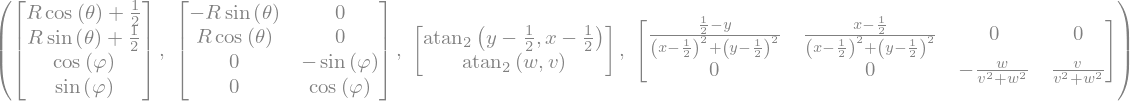

In [2]:
pol2cart = Matrix([R*cos(th)+half, R*sin(th)+half, cos(ph), sin(ph)])
Jpol2cart = pol2cart.jacobian([th, ph])

cart2pol = Matrix([atan2(y-half,x-half), atan2(w,v)])
Jcart2pol = cart2pol.jacobian([x,y,v,w])

pol2cart, Jpol2cart, cart2pol, Jcart2pol

Below we construct <b>Sout2Sin</b> which computes the intersection of a line and a circle provided a point and a vector on the line, and the center of the circle. We choose specifically the point of intersection closest to the given point on the line, we also do not add any precaution for when the line and circle do not intersect. We also immediately apply a translation back to the circle centered at $(1/2,1/2)$.

To find the intersection of the line and circle, we plug the equations of the line $(x(t),y(t)) = (x+vt,y+wt)$ into the equation of the circle $(x(t)-M_x-1/2)^2+(y(t)-M_y-1/2)^2=R^2$. We get a quadratic equation for the time $t$ of intersection, which we can solve for. The variable T is the time, the root formula for the quadratic equation is simplified already. To get the point of intersection, we plug T into the equations of the line.

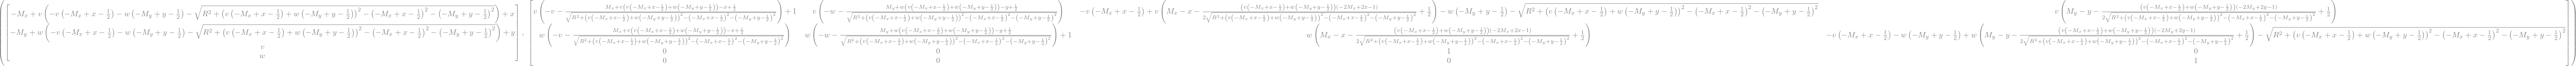

In [3]:
B = v*(x-Mx-half) + w*(y-My-half)
C = (x-Mx-half)**2 + (y-My-half)**2 - R**2
T = -B -sqrt(B**2-C)

Sout2Sin = Matrix([x + v*T - Mx, y + w*T - My, v, w])
JSout2Sin = Sout2Sin.jacobian(Matrix([x,y,v,w]))


Sout2Sin, JSout2Sin

Below we construct <b>Sin2Sout</b> which computes the position and velocity with which the trajectory exits the magnetic disc.

Consider two discs, and the line through their centers $\ell$. The circles are invariant under reflection in the line $A$, so if we know the position of one of the intersections, then we can find the other by reflection. The same idea goes for the tangent vector $v$ at the point of the intersection, we can reflect the vector in the line $Av$, and then take it with a minus sign $-Av$ to get the tangent vector pointing outward

The pair (a1,a2) is the center of the larmor circle shifted by $(-1/2,-1/2)$, so that the center of the magnetic circle is at (0,0). We construct $A$, from its diagonalization, we know that for reflection we have eigenvalues $1$ and $-1$, corresponding to a vector on the axis of reflection and a vector orthogonal to the axis, respectively. We take the first to be (a1,a2) and the second to be (-a2,a1), then X is a matrix with columns these two vectors. Finally, $A=XDX^{-1}$.

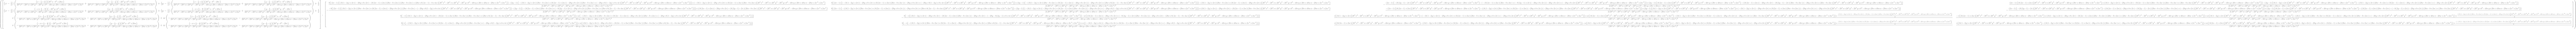

In [4]:
a1 = x + w/b - half
a2 = y - v/b - half
D = diag(1,-1)
X = Matrix([[a1, -a2],[a2, a1]])
A = X*D*(X**-1)

Sin2Sout = Matrix([[A, zeros(2)],[zeros(2), -A]])*Matrix([[x-half],[y-half],[v],[w]]) + Matrix([[half],[half],[0],[0]])
JSin2Sout = simplify(Sin2Sout.jacobian(Matrix([x,y,v,w])))
Sin2Sout, JSin2Sout

Below we compute the eigenvalues for the trajectory starting at $(\theta,\varphi)=(0,0)$ for field strength $b=3$. Mlist is a list of the Mx and My that are needed for this trajectory. The Jacobian is is computed at each composition of the maps to simplify the computation

Matrix([[0], [0]])
Matrix([[5/6], [1/2], [1], [0]])
[1, 0]   Matrix([[1/6], [1/2], [1], [0]])
[1, 0]   Matrix([[1/2], [1/6], [0], [-1]])
[0, -1]   Matrix([[1/2], [5/6], [0], [-1]])
[0, -1]   Matrix([[1/6], [1/2], [-1], [0]])
[-1, 0]   Matrix([[5/6], [1/2], [-1], [0]])
[-1, 0]   Matrix([[1/2], [5/6], [0], [1]])
[0, 1]   Matrix([[1/2], [1/6], [0], [1]])
[0, 1]   Matrix([[5/6], [1/2], [1], [0]])



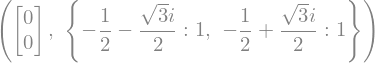

In [8]:
Mlist1 = [[1,0],[0,-1],[-1,0],[0,1]]

thinit1 = 0
phinit1 = 0

pol2cart1  =  pol2cart.subs(R,third)
Jpol2cart1 = Jpol2cart.subs(R,third)
Sin2Sout1  =  Sin2Sout.subs([[R, third], [b, 3]])
JSin2Sout1 = JSin2Sout.subs([[R, third], [b, 3]])
Sout2Sin1  =  Sout2Sin.subs([[R, third], [b, 3]])
JSout2Sin1 = JSout2Sin.subs([[R, third], [b, 3]])

Xstep1 =  pol2cart1.subs([[th, thinit1], [ph, phinit1]])
Jac1   = Jpol2cart1.subs([[th, thinit1], [ph, phinit1]])

print(Matrix([thinit1, phinit1]))
print(Xstep1)

for m in Mlist1:
    Jac1   = JSout2Sin1.subs(list(zip([x,y,v,w,Mx,My], list(Xstep1) + m))) * Jac1
    Xstep1 =  Sout2Sin1.subs(list(zip([x,y,v,w,Mx,My], list(Xstep1) + m)))
    print(m, ' ', Xstep1)
    Jac1   = JSin2Sout1.subs(list(zip([x,y,v,w], list(Xstep1)))) * Jac1
    Xstep1 =  Sin2Sout1.subs(list(zip([x,y,v,w], list(Xstep1))))
    print(m, ' ', Xstep1)
    

Jac1   = Jcart2pol.subs(zip([x,y,v,w], Xstep1)) * Jac1
Xstep1 =  cart2pol.subs(zip([x,y,v,w], Xstep1))

print()
eig1 = Jac1.eigenvals()
Xstep1, eig1

The iterations return to the correct point as we expect, and we see the eigenvalues have a real part with magnitude less than 1, which means that the periodic orbit of the map is attractive, and the trajectory of the continuous system is stable.

Below we repeat the same but for initial conditions $(\theta,\varphi)=(\delta,0)$, for $0<\delta<\pi/2$ and $b=3/\sin(\delta)$. Since throughout the iterations we carry a symbolic variable d the expressions get unwieldy unless we actively simplify them.

Matrix([[delta], [0]])
Matrix([[cos(delta)/3 + 1/2], [sin(delta)/3 + 1/2], [1], [0]])
[1, 0]   Matrix([[1/2 - cos(delta)/3], [sin(delta)/3 + 1/2], [1], [0]])
[1, 0]   Matrix([[1/2 - cos(delta)/3], [1/2 - sin(delta)/3], [-1], [0]])
[-1, 0]   Matrix([[cos(delta)/3 + 1/2], [1/2 - sin(delta)/3], [-1], [0]])
[-1, 0]   Matrix([[cos(delta)/3 + 1/2], [sin(delta)/3 + 1/2], [1], [0]])



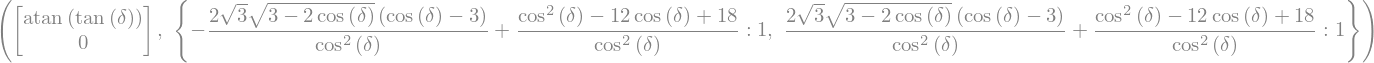

In [10]:
Mlist2 = [[1,0],[-1,0]]

thinit2 = d
phinit2 = 0

pol2cart2  =  pol2cart.subs(R, third)
Jpol2cart2 = Jpol2cart.subs(R, third)
Sin2Sout2  =  Sin2Sout.subs([[R, third], [b, 3/sin(d)]])
JSin2Sout2 = JSin2Sout.subs([[R, third], [b, 3/sin(d)]])
Sout2Sin2  =  Sout2Sin.subs([[R, third], [b, 3/sin(d)]])
JSout2Sin2 = JSout2Sin.subs([[R, third], [b, 3/sin(d)]])

Xstep2 =  pol2cart2.subs([[th, thinit2], [ph, phinit2]])
Jac2   = Jpol2cart2.subs([[th, thinit2], [ph, phinit2]])

print(Matrix([thinit2, phinit2]))
print(Xstep2)

for m in Mlist2:
    Jac2   = JSout2Sin2.subs(list(zip([x,y,v,w,Mx,My], list(Xstep2) + m))) * Jac2
    Jac2   = trigsimp(Jac2)
    Jac2   = refine(Jac2, Q.positive(cos(d)))
    Jac2   = trigsimp(Jac2)
    Jac2   = simplify(Jac2)
    Xstep2 =  Sout2Sin2.subs(list(zip([x,y,v,w,Mx,My], list(Xstep2) + m)))
    Xstep2 = trigsimp(Xstep2)
    Xstep2 = refine(Xstep2, Q.positive(cos(d)))
    Xstep2 = trigsimp(Xstep2)
    Xstep2 = simplify(Xstep2)
    print(m, ' ', Xstep2)
    Jac2   = JSin2Sout2.subs(list(zip([x,y,v,w], list(Xstep2)))) * Jac2
    Jac2   = trigsimp(Jac2)
    Jac2   = refine(Jac2, Q.positive(cos(d)))
    Jac2   = trigsimp(Jac2)
    Jac2   = simplify(Jac2)
    Xstep2 =  Sin2Sout2.subs(list(zip([x,y,v,w], list(Xstep2))))
    Xstep2 = trigsimp(Xstep2)
    Xstep2 = refine(Xstep2, Q.positive(cos(d)))
    Xstep2 = trigsimp(Xstep2)
    Xstep2 = simplify(Xstep2)
    print(m, ' ', Xstep2)
    

Jac2   = Jcart2pol.subs(zip([x,y,v,w], Xstep2)) * Jac2
Jac2 = trigsimp(Jac2)
Jac2 = refine(Jac2, Q.positive(cos(d)))
Jac2 = trigsimp(Jac2)
Jac2 = simplify(Jac2)
Xstep2 =  cart2pol.subs(zip([x,y,v,w], Xstep2))
Xstep2 = trigsimp(Xstep2)
Xstep2 = refine(Xstep2, Q.positive(cos(d)))
Xstep2 = refine(Xstep2, Q.positive(tan(d)))
Xstep2 = trigsimp(Xstep2)
Xstep2 = simplify(Xstep2)

print()

eig2 = Jac2.eigenvals()
Xstep2, eig2

Above, we see eigenvalues expressed as a function of $\delta$. It can be shown that the first eigenvalue has modulus greater than 1, while the second has modulus less than 1. So, the trajectory of the continuous system is unstable.

Below, we once more consider another example, the initial conditions are now again $(\theta, \varphi)=(0,0)$ but $b=3(\sqrt2-1)$. Once again, the code runs slow due to the simplification process.

Matrix([[0], [0]])
Matrix([[5/6], [1/2], [1], [0]])
[1, 0]   Matrix([[1/6], [1/2], [1], [0]])
[1, 0]   Matrix([[sqrt(2)/6 + 1/2], [1/2 - sqrt(2)/6], [sqrt(2)/2], [-sqrt(2)/2]])
[1, -1]   Matrix([[1/2 - sqrt(2)/6], [sqrt(2)/6 + 1/2], [sqrt(2)/2], [-sqrt(2)/2]])
[1, -1]   Matrix([[1/2], [1/6], [0], [-1]])
[0, -1]   Matrix([[1/2], [5/6], [0], [-1]])
[0, -1]   Matrix([[1/2 - sqrt(2)/6], [1/2 - sqrt(2)/6], [-sqrt(2)/2], [-sqrt(2)/2]])
[-1, -1]   Matrix([[sqrt(2)/6 + 1/2], [sqrt(2)/6 + 1/2], [-sqrt(2)/2], [-sqrt(2)/2]])
[-1, -1]   Matrix([[1/6], [1/2], [-1], [0]])
[-1, 0]   Matrix([[5/6], [1/2], [-1], [0]])
[-1, 0]   Matrix([[1/2 - sqrt(2)/6], [sqrt(2)/6 + 1/2], [-sqrt(2)/2], [sqrt(2)/2]])
[-1, 1]   Matrix([[sqrt(2)/6 + 1/2], [1/2 - sqrt(2)/6], [-sqrt(2)/2], [sqrt(2)/2]])
[-1, 1]   Matrix([[1/2], [5/6], [0], [1]])
[0, 1]   Matrix([[1/2], [1/6], [0], [1]])
[0, 1]   Matrix([[sqrt(2)/6 + 1/2], [sqrt(2)/6 + 1/2], [sqrt(2)/2], [sqrt(2)/2]])
[1, 1]   Matrix([[1/2 - sqrt(2)/6], [1/2 - sqrt(2)/6], [

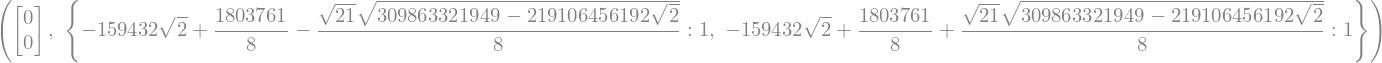

In [12]:
Mlist3 = [[1,0],[1,-1],[0,-1],[-1,-1],[-1,0],[-1,1],[0,1],[1,1]]

thinit3 = 0
phinit3 = 0

pol2cart3  =  pol2cart.subs(R,third)
Jpol2cart3 = Jpol2cart.subs(R,third)
Sin2Sout3  =  Sin2Sout.subs([[R, third], [b, 3*(sqrt(2)-1)]])
JSin2Sout3 = JSin2Sout.subs([[R, third], [b, 3*(sqrt(2)-1)]])
Sout2Sin3  =  Sout2Sin.subs([[R, third], [b, 3*(sqrt(2)-1)]])
JSout2Sin3 = JSout2Sin.subs([[R, third], [b, 3*(sqrt(2)-1)]])

Xstep3 =  pol2cart3.subs([[th, thinit3], [ph, phinit3]])
Jac3   = Jpol2cart3.subs([[th, thinit3], [ph, phinit3]])

print(Matrix([thinit3, phinit3]))
print(Xstep3)

for m in Mlist3:
    Jac3   = JSout2Sin3.subs(list(zip([x,y,v,w,Mx,My], list(Xstep3) + m))) * Jac3
    Jac3   = simplify(Jac3)
    Xstep3 =  Sout2Sin3.subs(list(zip([x,y,v,w,Mx,My], list(Xstep3) + m)))
    Xstep3 = simplify(Xstep3)
    print(m, ' ', Xstep3)
    Jac3   = JSin2Sout3.subs(list(zip([x,y,v,w], list(Xstep3)))) * Jac3
    Jac3   = simplify(Jac3)
    Xstep3 =  Sin2Sout3.subs(list(zip([x,y,v,w], list(Xstep3))))
    Xstep3 = simplify(Xstep3)
    print(m, ' ', Xstep3)
    

Jac3   = Jcart2pol.subs(zip([x,y,v,w], Xstep3)) * Jac3
Xstep3 =  cart2pol.subs(zip([x,y,v,w], Xstep3))

print()
eig3 = Jac3.eigenvals()
Xstep3, eig3

We arrive at some impressive looking eigenvalues, we evaluate them numerically in the next cell. We see that the eigenvalues are complex and their real parts have magnitude less than 1, so the trajectory is stable.

In [13]:
[ n.evalf() for n in eig3.keys()]